# Modeling ingredients recommender

The goal of this notebook is to prepare the datasets that we will use to train the Machine Learning Model

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### 1.1 Import and subset

In [2]:
reviews_ingredient = pd.read_pickle('data/to_sql/interactions_recipes_raw.pkl')

In [3]:
reviews_ingredient.shape

(3794003, 4)

In [4]:
subset = reviews_ingredient[:50000].drop('Unnamed: 0', errors='ignore')

In [5]:
subset.head()

,user_id,recipe_id,rating,ingredients
0,8542392,222388,5,"[pork belly, smoked paprika, kosher salt, grou..."
1,11174581,222388,5,"[pork belly, smoked paprika, kosher salt, grou..."
2,8262477,222388,5,"[pork belly, smoked paprika, kosher salt, grou..."
3,3574785,240488,5,"[sauerkraut drained, Granny Smith apples slice..."
4,12145410,240488,2,"[sauerkraut drained, Granny Smith apples slice..."


### 1.2. Reviews per ingredient

The goal is to obtain a table with reviews per ingredients. Similar to:

user_id | recipe_id | rating | ingredients
--------|--------|--------|--------|
int64 | int64 | int64 | object |

In [6]:
# Convert ingredients column to list type
subset = subset.explode('ingredients')

In [7]:
subset.head(10)

,user_id,recipe_id,rating,ingredients
0,8542392,222388,5,pork belly
0,8542392,222388,5,smoked paprika
0,8542392,222388,5,kosher salt
0,8542392,222388,5,ground black pepper
1,11174581,222388,5,pork belly
1,11174581,222388,5,smoked paprika
1,11174581,222388,5,kosher salt
1,11174581,222388,5,ground black pepper
2,8262477,222388,5,pork belly
2,8262477,222388,5,smoked paprika


In [8]:
# Drop 'recipe_id' rating
subset.drop('recipe_id', axis=1, inplace=True, errors='ignore')

## 2. Create feature set
based on user ratings for recipes that we are using to ingredients as well

Dataset design:

| ingredient | user1 | user2 | ... | userN |
|---------|-------|-------|-----|-------|
| pork belly | NA | 1 | ... | 5 |
| smoked paprika | 3 | NA | ... | 2 |

### 2.1 Filter ingredients with almost no ratings.

2. Count ratings for each ingredient
3. Join ratings on count from previous step
4. Fitler

In [9]:
# Count number of ratings
no_of_ratings_ingredient = (subset
                            .groupby("ingredients", as_index=True)
                            .agg({"user_id": "count"})
                            .rename(columns={"user_id": "no_of_ratings_ingredient"}))

In [10]:
no_of_ratings_ingredient

,no_of_ratings_ingredient
ingredients,
2-inch thick porterhouse steak at room temperature,2
99% fat-free chicken broth,1
Alfredo sauce,453
American cheese,160
Asian (toasted) sesame oil,32
...,...
zucchini cut into spirals using a spiral slicer,2
zucchini diced,1
zucchini thickly sliced,98


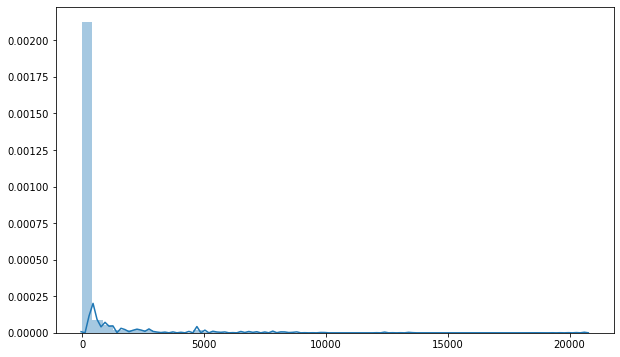

In [11]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings_ingredient);

In [12]:
no_of_ratings_ingredient.describe()

,no_of_ratings_ingredient
count,1674.00000
mean,343.64994
std,1253.72954
min,1.00000
25%,7.00000
50%,26.00000
75%,108.00000
max,20716.00000


We can see that there are many ingredients that have very few reviews while there is an ingredient that has 20.716 reviews. In the following graph we'll try to decide thich is the minimum reviews that an ingredient should have to continue with the model. We will try to build the model with a **min_threshold of 100**.

In [16]:
min_threshold_ingredient = 100

no_of_ratings_ingredient_subset = no_of_ratings_ingredient[no_of_ratings_ingredient['no_of_ratings_ingredient'] > min_threshold_ingredient]

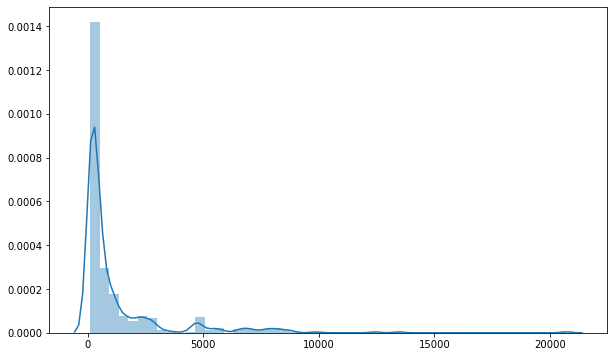

In [17]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings_ingredient_subset);

### 2.2 Filter ingredients with almost no ratings.

1. Count ratings per each user_id
2. Fitler

#### 2..2.1 Counting ratings per each user_id
We are going to identify which are the users that does not have enough ratings to be meaningful for our model

In [18]:
no_of_ratings_user = (subset
                      .groupby("user_id", as_index=True)
                      .agg({"rating": "count"})
                      .rename(columns={"rating": "no_of_ratings_user"}))

In [20]:
no_of_ratings_user.head()

,no_of_ratings_user
user_id,
39,43
148,9
240,38
338,36
424,10


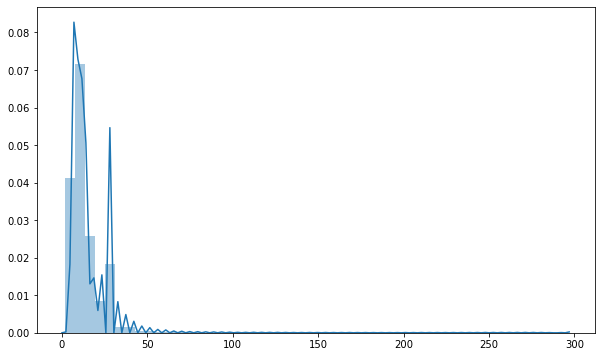

In [21]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings_user);

In [22]:
no_of_ratings_user.describe()

,no_of_ratings_user
count,42509.000000
mean,13.532899
std,10.507781
min,2.000000
25%,8.000000
50%,11.000000
75%,15.000000
max,295.000000


We can see that there are some users that have very few ratings while there are others with 295. In the following graph we'll try to decide thich is the minimum ratings that a user should have done in order to continue with the model. We will try to build the model with a **min_threshold of 10**.

### 2.2.2 Filter

In [25]:
min_threshold_user = 10

no_of_ratings_user_subset = no_of_ratings_user[no_of_ratings_user['no_of_ratings_user'] > min_threshold_user]

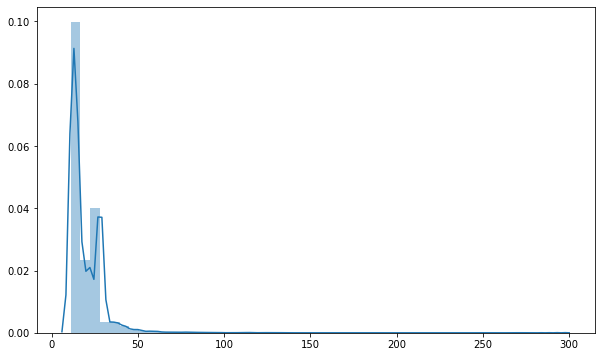

In [26]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings_user_subset);

In [27]:
no_of_ratings_user_subset.shape

(21854, 1)

### 3.2 Prepare the subset for the model
Now that we know with the ingredients and the users that we will keep for the model, we can prepare the dataset for the model. 

In [28]:
# Group subset by ingredient and avegage in case that a user rated an ingredient more than once
# subset = subset.groupby('ingredients').agg({'mean'})
# subset.reset_index(inplace=True)

In [29]:
subset.head()

,user_id,rating,ingredients
0,8542392,5,pork belly
0,8542392,5,smoked paprika
0,8542392,5,kosher salt
0,8542392,5,ground black pepper
1,11174581,5,pork belly


In [30]:
# Merge with number of ratings
subset_ml = (subset
             .merge(no_of_ratings_ingredient, how='left', on='ingredients')
             .merge(no_of_ratings_user, how='left', on='user_id'))

subset_ml.reset_index(drop=True, inplace=True)

In [31]:
subset_ml.head()

,user_id,rating,ingredients,no_of_ratings_ingredient,no_of_ratings_user
0,8542392,5,pork belly,3,11
1,8542392,5,smoked paprika,8,11
2,8542392,5,kosher salt,234,11
3,8542392,5,ground black pepper,13456,11
4,11174581,5,pork belly,3,4


In [32]:
# Drop ingredients with less than min_threshold_ingredient
final_ingredients = subset_ml[subset_ml['no_of_ratings_ingredient'] >= min_threshold_ingredient]

# Drop users with less than the min_threshols_user
final_ingredients = final_ingredients[final_ingredients['no_of_ratings_user'] >= min_threshold_user]

# Reset index
final_ingredients.reset_index(drop=True, inplace=True)

In [33]:
final_ingredients.shape

(453764, 5)

In [34]:
final_ingredients.head()

,user_id,rating,ingredients,no_of_ratings_ingredient,no_of_ratings_user
0,8542392,5,kosher salt,234,11
1,8542392,5,ground black pepper,13456,11
2,3574785,5,large onion,1138,12
3,3574785,5,brown sugar,2970,12
4,3574785,5,salt,20716,12


### 2.3 Create feature set


In [61]:
# Pivot tables
ingredient_features = final_ingredients.pivot_table(index="ingredients",
                                          columns="user_id",
                                          values="rating").fillna(0)

In [62]:
print(f"Number of users: {ingredient_features.shape[0]}")
print(f"Number of ingredients: {ingredient_features.shape[1]}")

Number of users: 439
Number of ingredients: 26584


In [63]:
ingredient_features.head(10)

user_id,39,240,338,424,521,650,1034,1552,1702,2079,...,23278229,23282556,23288084,23313487,23321072,23338764,23357046,23375614,23389673,23412582
ingredients,,,,,,,,,,,,,,,,,,,,,
Alfredo sauce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American cheese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Asian chile pepper sauce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cajun seasoning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
Chinese five-spice powder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0
Delmonico (rib-eye) steaks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dijon mustard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
For the glaze:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
French style green beans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Modelling
### 3.1 Unsupervised ML model 1.0

This model will take as an input and ingredient and return a list of 10 ingredients that users from allrecipes have also rated positively. 

In [64]:
from scipy.sparse import csr_matrix

In [65]:
mat_ingredient_features = csr_matrix(ingredient_features)

#### 3.1.1 Train KNN (K-Nearest-Neighbors)

In [66]:
from sklearn.neighbors import NearestNeighbors

In [67]:
model_knn = NearestNeighbors(metric="cosine",
                             algorithm="brute",
                             n_jobs=-1)

model_knn.fit(mat_ingredient_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [68]:
# In order to be able to start the program from here, I can export and import as a pickle
#with open("final-project/model_knn.pkl", "wb") as mk:
#    pickle.dump(model_knn, mk, protocol=pickle.HIGHEST_PROTOCOL)

In [69]:
ingredient_features.head()

user_id,39,240,338,424,521,650,1034,1552,1702,2079,...,23278229,23282556,23288084,23313487,23321072,23338764,23357046,23375614,23389673,23412582
ingredients,,,,,,,,,,,,,,,,,,,,,
Alfredo sauce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American cheese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Asian chile pepper sauce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cajun seasoning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
Chinese five-spice powder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0


In [73]:
ingredient_features.loc['Alfredo sauce'].values.reshape(1, -1)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [75]:
input_ = 'Alfredo sauce'

In [76]:
model_knn.kneighbors(ingredient_features.loc[input_].values.reshape(1, -1), n_neighbors=5)
# print(f'Array with the distance of the ingredients: {model_knn.kneighbors(ingredient_features.loc['Dijon mustard'].values.reshape(1, -1), n_neighbors=5)[0]}')
# print(f'Array with the id of the ingredients: {model_knn.kneighbors(ingredient_features.loc['Dijon mustard'].values.reshape(1, -1), n_neighbors=5)[1]}')

(array([[5.77315973e-15, 5.77315973e-15, 5.77315973e-15, 5.77315973e-15,
         7.93414385e-03]]),
 array([[322,   0, 200,  66, 137]]))

Our kNN model returns a tuple of two 2d-arrays, containing distances and indeces of the nearest neighbors of the vector passed. In order for us to match the results with 'ingredients', we need to translate the output.

In [101]:
result = model_knn.kneighbors(ingredient_features.loc[input_].values.reshape(1, -1), n_neighbors=10)

In [102]:
result[1][0][2]

200

In [103]:
ingredient_features.iloc[result[1][0][2]].name

'fresh baby spinach'

In [104]:
print(f'If you are buying {input_} you may also want to buy:')
print(f'---------------------------------------------------------')

print(f'1. {ingredient_features.iloc[result[1][0][0]].name}')
print(f'2. {ingredient_features.iloc[result[1][0][1]].name}')
print(f'3. {ingredient_features.iloc[result[1][0][2]].name}')
print(f'4. {ingredient_features.iloc[result[1][0][3]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][4]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][5]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][6]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][7]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][8]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][9]].name}')

If you are buying Alfredo sauce you may also want to buy:
---------------------------------------------------------
1. pesto sauce
2. Alfredo sauce
3. fresh baby spinach
4. box penne pasta
5. cubed cooked chicken
5. shredded Italian cheese blend
5. seasoned bread crumbs
5. crushed tomatoes
5. milk
5. grated Parmesan cheese


The model works with 1 ingredient as an input, however, we would like to be able to give multiple ingredients as arguments. To do so, we are going to try to create a numpy array and pass it as the input.

### 3.2 Unsupervised ML model 2.0

This model will take as an input a LIST of ingredients and return a list of 10 ingredients that users from allrecipes have also rated positively. 

In [122]:
input_list = ['American cheese', 'Dijon mustard']
input_arr = np.array(input_list) 
input_arr

array(['American cheese', 'Dijon mustard'], dtype='<U15')

In [126]:
ingredient_features.loc[['American cheese', 'Dijon mustard']]

user_id,39,240,338,424,521,650,1034,1552,1702,2079,...,23278229,23282556,23288084,23313487,23321072,23338764,23357046,23375614,23389673,23412582
ingredients,,,,,,,,,,,,,,,,,,,,,
American cheese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dijon mustard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [127]:
ingredient_features.loc[['American cheese', 'Dijon mustard']].values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 5., 0.]])

In [128]:
ingredient_features.loc[['American cheese', 'Dijon mustard']].values#.reshape(1, -1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 5., 0.]])

#### 3.2.1 Finding top 10 recommendations
In order to find the closest recommendations od a list of ingredients we are going to create a dataframe that will look like the following: 

|Ingredient Position|Distance|
|----|----|
|202|0.84|
|...|...|

We will append the output from the KNN model for each ingredient and then group them by ingredient to obtain the mean 'Distance'. With that we will be able to sort by distance in a Descending order and obtain the Top10 recommended ingredients.

In [180]:
model_knn.kneighbors(ingredient_features.loc[input_arr].values, n_neighbors=10)


(array([[0.00000000e+00, 6.51015629e-02, 3.59549100e-01, 4.79292402e-01,
         8.35601644e-01, 8.52459011e-01, 8.54745352e-01, 8.75340102e-01,
         8.84598073e-01, 9.07546181e-01],
        [8.99280650e-15, 4.34876184e-01, 4.34876184e-01, 4.34876184e-01,
         4.34876184e-01, 4.34876184e-01, 4.85608695e-01, 4.85608695e-01,
         4.85608695e-01, 4.90243531e-01]]),
 array([[  1, 310,  11, 411, 218, 227, 308, 180, 156, 229],
        [  6, 403, 185, 437, 153, 183,  79, 181, 224, 172]]))

In [183]:
ingredient_features.iloc[180].name

'evaporated milk'

In [133]:
knn = model_knn.kneighbors(ingredient_features.loc[input_arr].values, n_neighbors=10)

In [174]:
# Zip the ingredients position with the distance to the input 'ingredient'
z = zip(knn[1][0].tolist(), knn[0][0].tolist())

In [175]:
# Formate it as a list
z_list = [(x, y) for x, y in z]

z_list

# I have to drop the first row

[(1, 0.0),
 (310, 0.06510156288541236),
 (11, 0.3595490997765878),
 (411, 0.4792924019455831),
 (218, 0.8356016435665717),
 (227, 0.8524590105736074),
 (308, 0.8547453523168156),
 (180, 0.87534010234885),
 (156, 0.8845980732450233),
 (229, 0.907546180868204)]

In [190]:
model = pd.DataFrame(z_list, columns=('Ingredient Position', 'Distance'))

In [191]:
model

,Ingredient Position,Distance
0,1,0.000000
1,310,0.065102
2,11,0.359549
3,411,0.479292
4,218,0.835602
5,227,0.852459
6,308,0.854745
7,180,0.875340
8,156,0.884598
9,229,0.907546


In [194]:
model = model.drop(model[model['Distance'] == 0].index).reset_index(drop=True)

In [195]:
model

,Ingredient Position,Distance
0,310,0.065102
1,11,0.359549
2,411,0.479292
3,218,0.835602
4,227,0.852459
5,308,0.854745
6,180,0.875340
7,156,0.884598
8,229,0.907546


Once understood how to create the DataFrame that we are looking for, lets create a for loop that creates it for the whole list of ingredients

In [291]:
def get_top10_recommendations(ingredients:list):

    input_arr = np.array(ingredients)
    
    # Create empty DataFrame
    model = pd.DataFrame(columns=('Ingredient Position', 'Distance'))
    
    # Generate the model
    knn = model_knn.kneighbors(ingredient_features.loc[input_arr].values, n_neighbors=10)
    
    for i, ing in enumerate(ingredients):
        
        # Zip the ingredients position with the distance to the input 'ingredient'
        z = zip(knn[1][i].tolist(), knn[0][i].tolist())
        
        # Formate it as a list
        z_list = [(x, y) for x, y in z]
    
        # Create the DataFrame
        temp = pd.DataFrame(z_list, columns=('Ingredient Position', 'Distance'))
        
        # Drop the rows of the ingredients that are already in our list
        temp = temp.drop(temp[temp['Distance'] <= 0.001].index)

        # Concat the new list of (Position, Distance) with the final df
        model = pd.concat([model, temp])
        
    # Group by ingredient position and sort by distance
    model = model.groupby('Ingredient Position').agg({'Distance': 'mean'})
    model = model.sort_values(by='Distance', ascending=True).reset_index()
    
    # Print output header
    print(f'If you are buying {input_list} you may also want to buy:')
    print(f'---------------------------------------------------------')
    
    for x in range(0, 10):
        # Print a list with the top 10 recommendations
        print(f'{x}.{ingredient_features.iloc[model["Ingredient Position"][x]].name}')
    
    return model.head(10)
        

In [292]:
ingredient_features.iloc[model['Ingredient Position'][2]].name

'teriyaki sauce'

In [293]:
get_top10_recommendations(['American cheese', 'Dijon mustard', 'grated Parmesan cheese'])

If you are buying ['American cheese', 'Dijon mustard'] you may also want to buy:
---------------------------------------------------------
0.onion rolls
1.fresh mushrooms sliced
2.Cajun seasoning
3.linguine pasta
4.lemon pepper
5.Italian seasoned bread crumbs
6.green onion
7.heavy cream
8.garlic powder
9.sun-dried tomatoes chopped


,Ingredient Position,Distance
0,310,0.065
1,201,0.299
2,3,0.341
3,285,0.341
4,280,0.341
5,11,0.360
6,222,0.361
7,246,0.372
8,213,0.428
9,403,0.435


---

Once we have our first version of the recommender we conclude that: 
- We can see that the recommender is not very useful since the ingredients that is recommending are very specific (e.g. 'Asian chile pepper sauce').
- There are so many ingredients and won't be very user friendly

-----------------
### Next Steps

## Make recommender more user friendly

### #. Possible analysis
- Which are the 25 recipes with more reviews
- Is there a correlation between number of reviews and score. Hyphotesis, the higher the number of reviews the higher the score?
- Is there any correlation between the number of ingredients of a recipe and the rating/number of reciews?